In [1]:
!git clone https://github.com/google/deluca.git

Cloning into 'deluca'...
remote: Enumerating objects: 2604, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 2604 (delta 249), reused 187 (delta 169), pack-reused 2297 (from 2)
Receiving objects: 100% (2604/2604), 3.23 MiB | 5.83 MiB/s, done.
Resolving deltas: 100% (1590/1590), done.


In [2]:
%cd deluca

!pip install -e .

/content/deluca
Obtaining file:///content/deluca
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 476.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.2/711.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 13.9 MB/s eta 0:00:00
  Running setup.py develop for deluca


#This cell creates an LDS environment and plots the signal with random activations.

trajectory length = 1000


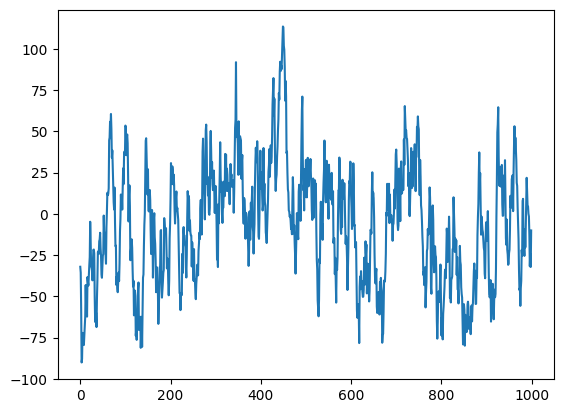

In [3]:
%load_ext autoreload
%autoreload 2
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from deluca.core import Env
from deluca.core import field
from deluca.envs import _lds as lds
from deluca.envs._lds import SinusDisturbance



env = lds.LDS() #LDS with random initiations and dimensions as specified
#env = lds.LDS(2,10,3) #LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)
env.show_me_the_signal(1000)

Now I'd like to plot the signal with different activations, but instead of a build in function, i want to use agents.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


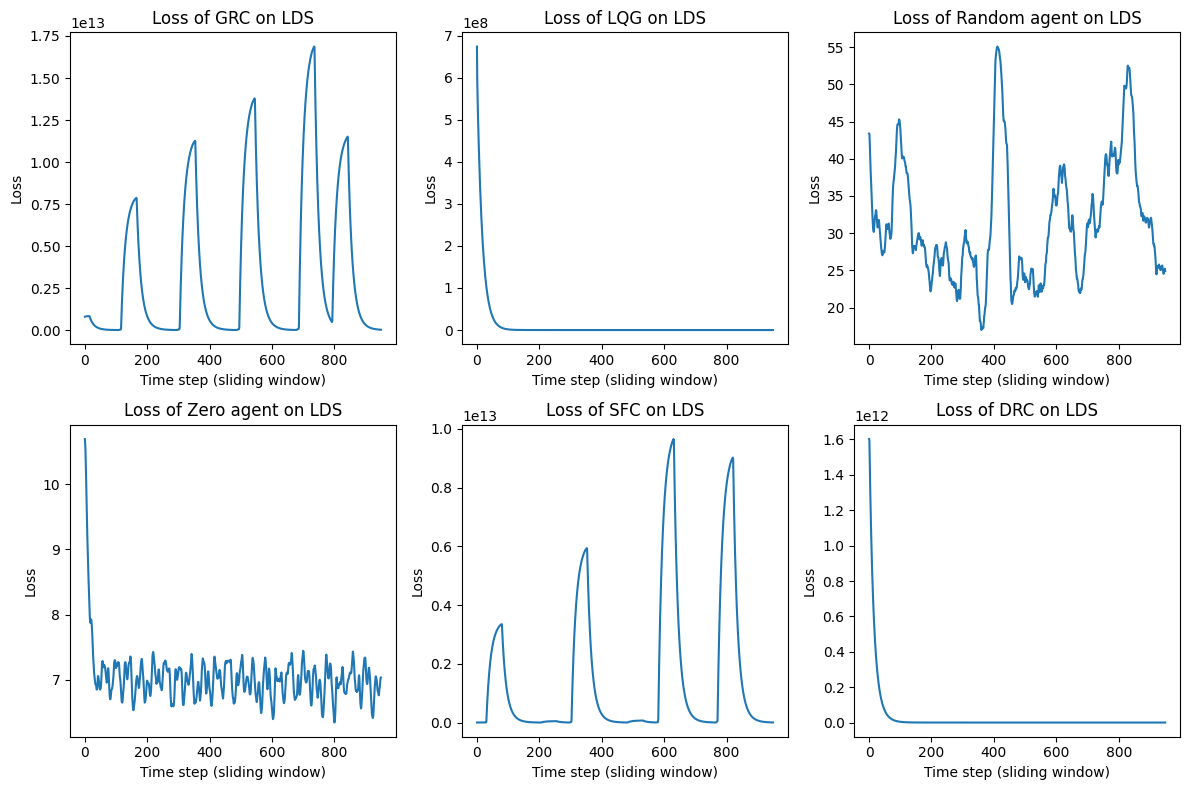

In [17]:
# prompt: I want the same cell as above, but plot the figures side by side
%load_ext autoreload
%autoreload 2
from deluca.core import Agent
from deluca.agents._grc import GRC
from deluca.agents._random import SimpleRandom
from deluca.agents._lqg import LQG
from deluca.agents._zero import Zero
from deluca.agents._sfc import SFC
from deluca.agents._drc import DRC

import matplotlib.pyplot as plt
import numpy as np

def plot_lds_with_a_given_agent(env, agent, name_of_agent, traj_length=1000, window_size=50, ax=None):
    obs = np.zeros(shape=(d_obs, 1))
    action = agent(obs)
    losses = np.zeros(traj_length)
    window_losses = np.zeros(traj_length - window_size)

    for i in range(traj_length):
        obs = env(action)
        action = agent(obs)
        losses[i] = np.linalg.norm(obs) + np.linalg.norm(action) # simple quadratic loss
        agent.update(obs, action)
        if i >= window_size - 1:
            window_losses[i - window_size] = np.mean(losses[i - window_size + 1: i + 1])

    ax.plot(window_losses)
    ax.set_xlabel('Time step (sliding window)')
    ax.set_ylabel('Loss')
    ax.set_title(f"Loss of {name_of_agent} on LDS")


env = lds.LDS()  # LDS with random initiations and dimensions as specified
d_obs = 2
d_action = 3
d_hidden = 10
disturbance = SinusDisturbance()
disturbance.init(d_hidden, 0.5)
obs = env.init(d_action,d_hidden,d_obs, disturbance = disturbance)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()


agent = GRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "GRC", ax=axes[0])

agent = LQG(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "LQG", ax=axes[1])

agent = SimpleRandom(d_action)
agent.init()
plot_lds_with_a_given_agent(env, agent, "Random agent", ax=axes[2])

agent = Zero(d_action)
agent.init(d_action)
plot_lds_with_a_given_agent(env, agent, "Zero agent", ax=axes[3])

agent = SFC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "SFC", ax=axes[4])

agent = DRC(env.A, env.B, env.C)
agent.init()
plot_lds_with_a_given_agent(env, agent, "DRC", ax=axes[5])


plt.tight_layout()
plt.show()